This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import gc
import math
import random
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from tqdm.auto import tqdm
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

class CFG:
    seed = 46
    train = True
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

# %cd /content/drive/MyDrive/kaggle/foursquare-location-matching/{CFG.expID}

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 600)

# Get the dataset

In [4]:
train = pd.read_csv("foursquare-location-matching/train.csv")
test = pd.read_csv("foursquare-location-matching/test.csv")
test[CFG.target] = "TEST"

train.head(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


# 1. EDA

## Train shape and dtypes

In [5]:
print(f"Train shape is {train.shape}\n")

train.dtypes

Train shape is (1138812, 13)



id                    object
name                  object
latitude             float64
longitude            float64
address               object
city                  object
state                 object
zip                   object
country               object
url                   object
phone                 object
categories            object
point_of_interest     object
dtype: object

### Train nulls

In [6]:
train.isnull().sum()

id                        0
name                      1
latitude                  0
longitude                 0
address              396621
city                 299189
state                420586
zip                  595426
country                  11
url                  871088
phone                795957
categories            98307
point_of_interest         0
dtype: int64

## ID

In [7]:
assert len(train) == len(train['id'].unique())

## Name

### Unique values

In [8]:
print(f"Number of unique names is {len(train['name'].unique())}")

Number of unique names is 842087


### Plot most popular names

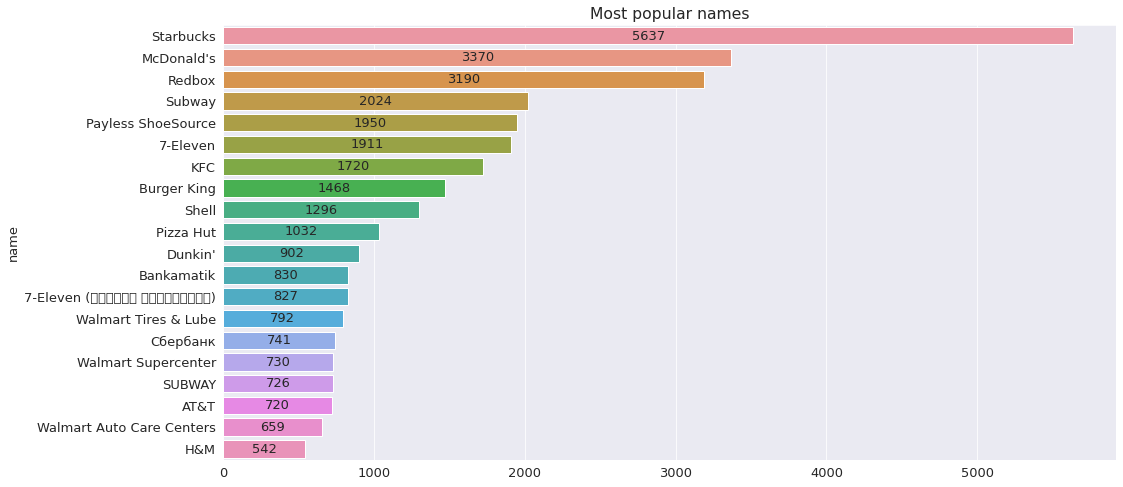

In [9]:
plt.figure(figsize=(16, 8))
plt.title('Most popular names')

d = train['name'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Get unique categories

In [ ]:
cat_freq = dict()
stop_words = ['/', '&', 'or', 'High', 'Miscellaneous', 'Fast', 'Other', 'Asian', 'Chinese', 'Event', 
              'Great', 'Noodle', 'Burger', 'Seafood', 'Breakfast', 'Ice', 'Diners', 'Cream', 'Indonesian', 
              'Thai', "Women's", 'Fried', 'Snack', 'Tea', 'Mexican', 'Nail', 'Sushi', 'Middle', 'Korean', 
              'Gift', 'Drink', 'Pet', 'Turkish', "Men's", 'Indian', 'Malay', 'Cocktail', 'Donut', 'Box', 
              'Condos)', 'Residential', 'Convenience', 'Gas', 'General', 'Bus', 'Pizza', 'Spaces', 'Mobile',
              'Phone', 'Academic', 'Japanese', 'Business', 'Shoe', 'Italian', 'American', 'Home', 'Auto', 
              'Furniture', 'Cosmetics', 'Sandwich', 'Dessert', 'Car', 'Arts', 'Financial', 'Legal', 'BBQ',
              'Hardware', 'Video', 'Music', 'Art', 'Student', 'Jewelry', 'Historic', 'Travel', 'Washes',
              'Beer', 'Arcades', 'Bike', 'Lookouts', 'Scenic', 'Rental', 'Accessories', 'Repairs', 'Discount', 
              'Optical', 'Bodegas', 'Big', 'Assisted', 'Living', 'Athletics', 'Agencies', 'Locations', 'Trails', 
              'Bed', 'Breakfasts', 'Wine', 'Real', 'Elementary', 'Theme', 'Golf', 'Rest',  'Photography', 
              'Nightlife', 'Courses', 'Convention', 'Eastern', 'Concert', 'Conference', 'Startups', 'Tech', 
              'Meeting', 'French', 'Supplies', 'Events', 'Sake', 'Dog', 'Ramen', 'City', 'Juice', 'Science',
              'Liquor', 'Lawyers', 'Insurance', 'Flower', 'Toy', 'Rentals', 'Paper', 'Flea', 'Bases', 'Baseball', 
              'Karaoke', 'Kids', 'Design', 'Farmers', 'Repair', 'Technology', 'Wards', 'Water', 'Supply', 
              'Filipino', 'Piers', 'Salad', 'Mattress', 'Print', 'Wings', 'Engineering', 'Non-Profits', 
              'Gastropubs', 'Bistros', 'Hot', 'Vietnamese', 'Hookah', 'Candy', 'Coffee', 'Electronics',
              'Department', 'Clothing', 'Trucks', 'Chicken', 'Movie', 'Health', 'Soccer', 'Crafts', 
              'Game', 'Community', 'Food', 'College', 'Sporting', 'Beauty', 'Ferries', 'Soup', 'Veterinarians', 
              'Basketball', 'Light', 'Rail', 'Taco', 'Classrooms', 'Shopping', 'Developments', 'Train', 'Performing',
              'Administrative', 'Lingerie', 'Dive', 'Storage', 'Office', 'Landscaping', 'Residence', 'Sports',
              'Goods', 'Dealerships', 'Grocery', 'Workshops', 'History'
             ]

for category in tqdm(train['categories']):
    if category == category:
        category_list = category.split(', ')
        for cat in category_list:
            cat_list = cat.split(' ')
            for c in cat_list:
                if c == 'Auto':
                    c = 'Automotive'
                if c == 'Hotel' or c == 'Motels' or c == 'Hostels':
                    c = 'Hotels'
                if c == 'Courthouses':
                    c = 'Court'
                if c == 'College':
                    c == 'Colleges'
                if c == 'Cafés':
                    c = 'Cafes'
                if c == "Doctor's" or c == "Dentist's" or c == "Doctors":
                    c = 'Medical'
                if c in stop_words or c[-2:] == 'an':
                    continue
                if c == '(Apartments':
                    c = c[1:]
                x = cat_freq.get(c, 0) + 1
                cat_freq[c] = x
            
cat_freq = pd.DataFrame(cat_freq.items(), 
                        columns=['category', 'frequence']).sort_values('frequence', 
                                                                        ascending=False).reset_index(drop=True)
cat_freq = cat_freq.iloc[:108]
cat_freq.head()

  0%|          | 0/1138812 [00:00<?, ?it/s]

,category,frequence
0,Restaurants,146728
1,Stores,129584
2,Shops,109316
3,Buildings,73062
4,Offices,50046
5,Stations,34506
6,Cafes,33535
7,Bars,30557
8,Apartments,29268
9,Places,28165


In [323]:
train_cats = train['categories'].unique()

all_cats = list()

for cat in train_cats:
    if cat == cat:
        cat_list = cat.split(', ')
    
        for c in cat_list:
            if c not in all_cats:
                all_cats.append(c)
            
cats_freq = dict()

for c in all_cats:
    c_list = c.split(' ')
    for c_l in c_list:
        if c_l not in ['&', '/']:
            x = cats_freq.get(c_l, 0) + 1
            cats_freq[c_l] = x
            
cats_freq = pd.DataFrame(cats_freq.items(), 
                         columns=['category', 'frequence']).sort_values('frequence', 
                                                                        ascending=False).reset_index(drop=True)
cats_freq.head()

,category,frequence
0,Restaurants,224
1,Shops,62
2,Stores,51
3,College,29
4,Places,27


### Plot most popular categories

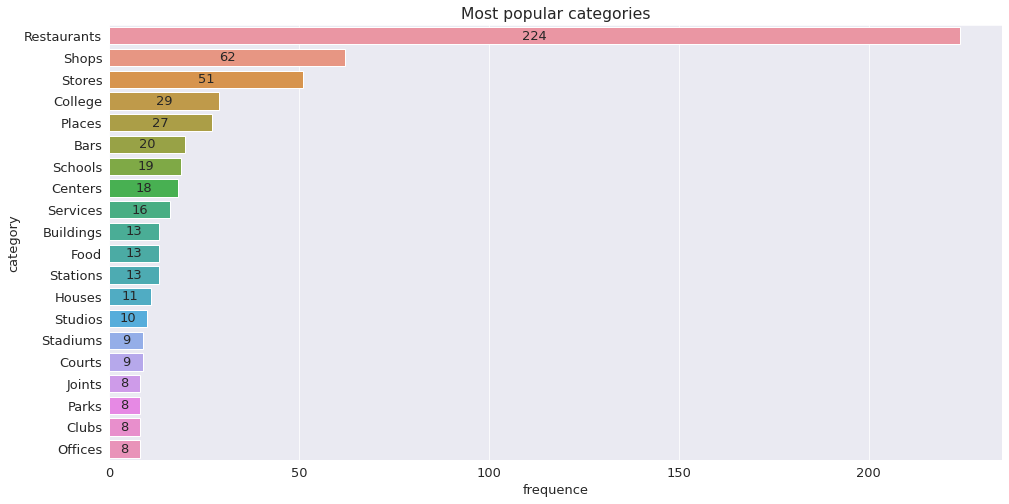

In [196]:
plt.figure(figsize=(16, 8))
plt.title('Most popular categories')

d = cats_freq.head(20)
ax = sns.barplot(x='frequence', y='category', data=d, orient='h')
br = ax.bar_label(ax.containers[0], label_type='center')

## Lattitude and longitude



### 10 most popular lat and lon values

In [10]:
lat_lon_group = train.groupby(['latitude', 'longitude'], as_index=False).agg({'id': 'count', 
                                                                              'name': 'first'}).rename({'id': 'count'}, axis=1).sort_values('count', 
                                                                                                                                            ascending=False)
lat_lon_group.head(10)

,latitude,longitude,count,name
678212,38.415602,-95.925751,1437,gucci男士内裤-一比一原单A货奢侈品他
694126,38.748285,30.548825,48,Emniyet Parkı
725211,39.779379,-75.555298,45,"Cara J. Lasley, MD"
114208,-6.914744,107.609811,38,XI IPA 4 SMAN 25 Bandung
905361,44.480641,-73.196685,36,"Adam Preston Buckley, MD"
192734,1.311910,124.837240,22,El Pollo Gordo Restaurant
193370,1.317170,124.838060,20,Southern Fried Chicken Restaurants
678151,38.413248,-95.925751,20,"Collection - 哪里买一比一lv迷你双肩包货源,哪里有卖瓜"
969105,50.000000,5.000000,19,Champia - Arrêt de bus TEC
145913,-6.211544,106.845172,18,"""Waroeng Spesial Sambal \""SS\"""""


### Unique lat and lon pairs

In [11]:
len(lat_lon_group)

1128847

## City

### Unique values

In [12]:
print(f"Number of unique cities is {len(train['city'].unique())}")

Number of unique cities is 68106


### Most popular cities

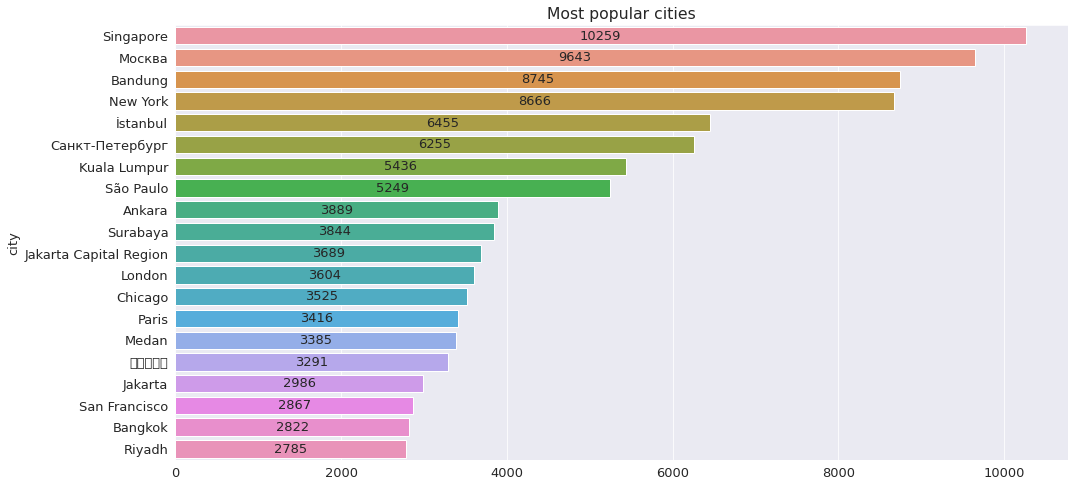

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Most popular cities')

d = train['city'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## State

### Unique values

In [14]:
print(f"Number of unique states is {len(train['state'].unique())}")

Number of unique states is 17597


### Most popular states

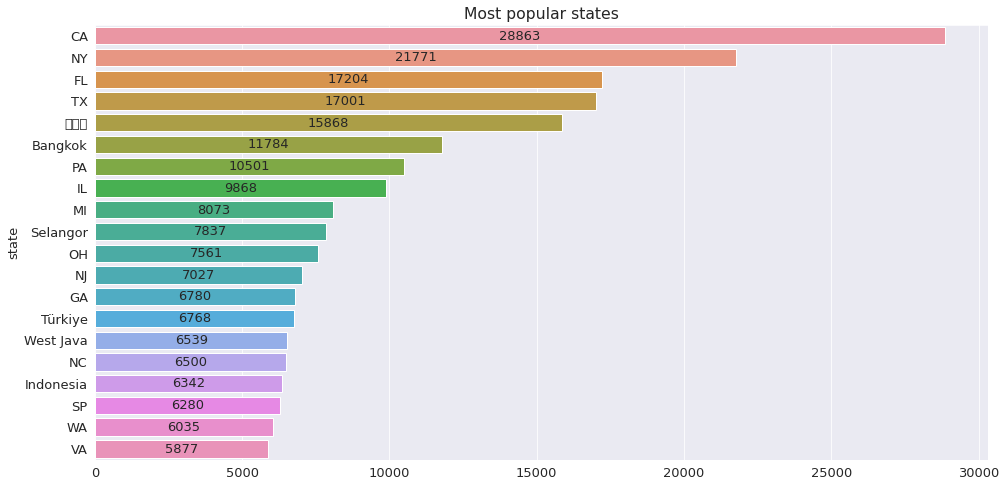

In [15]:
plt.figure(figsize=(16, 8))
plt.title('Most popular states')

d = train['state'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Country

### Unique values

In [16]:
print(f"Number of unique countries is {len(train['country'].unique())}")

Number of unique countries is 222


### Most popular countries

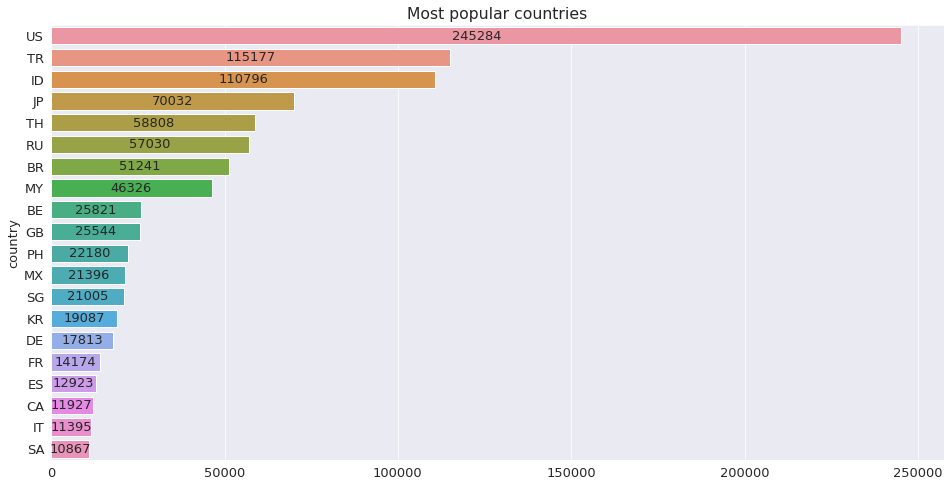

In [17]:
plt.figure(figsize=(16, 8))
plt.title('Most popular countries')

d = train['country'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Points of interest

### Unique values

In [18]:
print(f"Number of unique categories is {len(train['point_of_interest'].unique())}")

Number of unique categories is 739972


### Most popular POIs

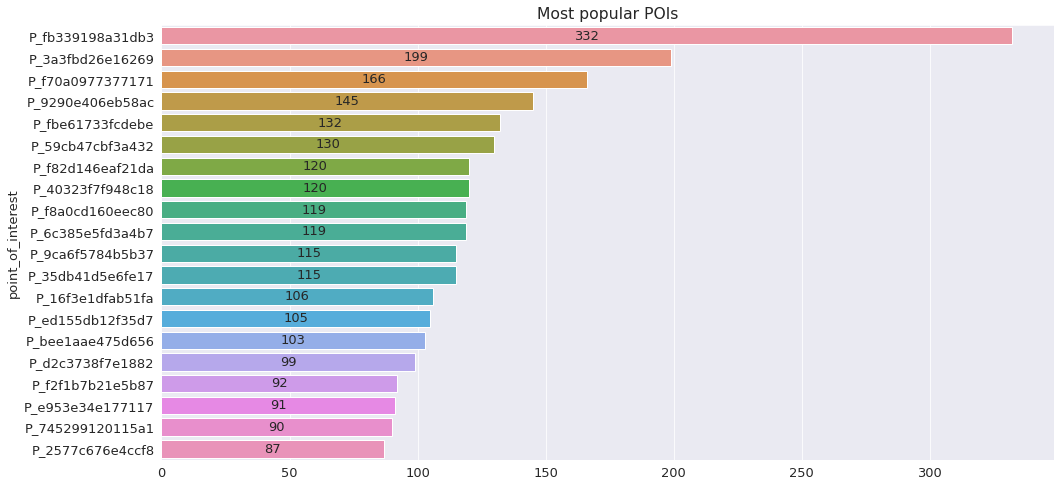

In [19]:
plt.figure(figsize=(16, 8))
plt.title('Most popular POIs')

d = train['point_of_interest'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

### Count number of POI without match

In [20]:
group_poi = train.groupby('point_of_interest', as_index=False).agg({'id': 'count'})
group_poi[group_poi['id'] == 1].shape[0]

425024

# Divide Train Data into about 600K×2

This is because test set size is about 600K, so we want our model to train on KNN embeddings built on datasets of similar size.

In [21]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

# Search Candidates

In [22]:
from sklearn.neighbors import KNeighborsRegressor

def create_target(row):
    if row[CFG.target] == row['near_target_0']:
        return 1
    return 0

def add_neighbor_features(df, train_mode=True):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)

        targets = country_df[CFG.target].values
        
        for i in range(1, min(len(country_df), CFG.n_neighbors)):
            for j in range(1, min(len(country_df), CFG.n_neighbors)):
                temp_df = country_df.copy()
                if j < i:
                    country_df[f"d_near_{j}"] = dists[:, j]
                    country_df[f"near_target_{j}"] = targets[nears[:, j]]
                    for c in columns:
                        country_df[f"near_{c}_{j}"] = country_df[c].values[nears[:, j]]
                elif j > i:
                    country_df[f"d_near_{j-1}"] = dists[:, j]
                    country_df[f"near_target_{j-1}"] = targets[nears[:, j]]
                    for c in columns:
                        country_df[f"near_{c}_{j-1}"] = country_df[c].values[nears[:, j]]
                else:
                    country_df[f"d_near_0"] = dists[:, j]
                    country_df[f"near_target_0"] = targets[nears[:, j]]
                    for c in columns:
                        country_df[f"near_{c}_0"] = country_df[c].values[nears[:, j]]    

            for j in range(min(len(country_df), CFG.n_neighbors), CFG.n_neighbors):
                country_df[f"d_near_{j}"] = np.nan
                country_df[f"near_target_{j}"] = np.nan
                for c in columns:
                    country_df[f"near_{c}_{j}"] = np.nan

            dfs.append(temp_df)
        
    df = pd.concat(dfs).reset_index(drop=True)
    
    if train_mode:
        df['target'] = df.apply(create_target, axis=1)
    
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1])
])
test = add_neighbor_features(test, train_mode=False)

gc.collect()

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

729

# Balance train dataset

In [23]:
train = train.reset_index(drop=True)

# select indexes of all positive targets
# and select indexes of all ids that don't have postive targets at all
pos_ids = train.loc[train['target'] == 1, 'id'].unique()
pos_idxs = train[train['target'] == 1].index
neg_idxs = train.loc[~train['id'].isin(pos_ids), 'id'].drop_duplicates(keep='first').index

# additionally select indexes of ids that have negative target
# but may have positive target 
neg_idxs1 = train[train['target'] == 0].index
neg_idxs1 = neg_idxs1.difference(neg_idxs)
neg_idxs1 = np.random.choice(neg_idxs1, size=len(pos_idxs)-len(neg_idxs))

# and add them to negative indexes, so the total number of positive and negative indexes are equal
neg_idxs = neg_idxs.union(neg_idxs1)

# select these positive and negative indexes from the dataset
train = train.loc[pos_idxs.union(neg_idxs)]

gc.collect()

train['target'].value_counts()

0    1437548
1     718774
Name: target, dtype: int64

# Check Maximum Score

In [24]:
# # https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
# def get_id2poi(input_df: pd.DataFrame) -> dict:
#     return dict(zip(input_df['id'], input_df['point_of_interest']))

# def get_poi2ids(input_df: pd.DataFrame) -> dict:
#     return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

# def get_score(input_df: pd.DataFrame):
#     scores = []
#     for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
#         targets = poi2ids[id2poi[id_str]]
#         preds = set(matches.split())
#         score = len((targets & preds)) / len((targets | preds))
#         scores.append(score)
#     scores = np.array(scores)
#     return scores.mean()

# id2poi = get_id2poi(train)
# poi2ids = get_poi2ids(train)

In [25]:
# scores = []

# train["matches"] = ""
# for i in tqdm(range(CFG.n_neighbors)):
#     idx = train[CFG.target]==train[f"near_target_{i}"]
#     train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
#     scores.append(get_score(train))
# train["mathces"] = None

In [26]:
# plt.subplots(figsize=(8, 3), facecolor="white")
# plt.plot(range(CFG.n_neighbors), scores, marker="o")
# plt.grid()
# plt.xlabel("# of candidates")
# plt.ylabel("Maximum Score")
# plt.ylim([0.6, 1.0])
# plt.show()

In [27]:
# del train
# gc.collect()

# Feature Engineering

In [28]:
%load_ext Cython

In [29]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [30]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for i in tqdm(range(CFG.n_neighbors)):
        for c in columns:
            geshs = []
            levens = []
            jaros = []
            lcss = []
            for str1, str2 in df[[c, f"near_{c}_{i}"]].values.astype(str):
                if str1==str1 and str2==str2:
                    geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                    levens.append(Levenshtein.distance(str1, str2))
                    jaros.append(Levenshtein.jaro_winkler(str1, str2))
                    lcss.append(LCS(str(str1), str(str2)))
                else:
                    geshs.append(-1)
                    levens.append(-1)
                    jaros.append(-1)
            df[f"near_{c}_{i}_gesh"] = geshs
            df[f"near_{c}_{i}_leven"] = levens
            df[f"near_{c}_{i}_jaro"] = jaros
            df[f"near_{c}_{i}_lcs"] = lcss
            
            if not c in ['country', "phone", "zip"]:
                df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
                df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
                df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
                df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()-1
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train = add_distance_features(train)
# test = add_distance_features(test)

0it [00:00, ?it/s]

# Delete unused columns (just to avoid OOM)

In [31]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']
for i in tqdm(range(CFG.n_neighbors)):
    features.append(f"d_near_{i}")
    for c in columns:        
        features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
        if c in ['country', "phone", "zip"]:
            features += [f"near_{c}_{i}_leven"]
        else:
            features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
    if f not in test.columns:
        test[f] = np.nan


  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
# test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

train[features] = train[features].astype(np.float16)
# test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)
train["near_id_0"] = train["near_id_0"].fillna('')

train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156322 entries, 0 to 2156321
Columns: 563 entries, d_near_0 to near_id_9
dtypes: float16(550), float64(1), int64(1), object(11)
memory usage: 2.4+ GB


# Model train

In [33]:
import lightgbm as lgb
from scipy.misc import derivative


def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    cat_features = X.select_dtypes(include='object').columns
    
    models = []
    oof = np.zeros(len(y), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds != i
        val_idx = folds == i
        
        train_dataset = lgb.Dataset(X.iloc[trn_idx], y.iloc[trn_idx], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx], categorical_feature=cat_features)

        
        focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=1., gamma=1.)
        focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=1., gamma=1.)
        
        if model_dir is None:
            model = lgb.train(
                params,
                train_set = train_dataset, 
                valid_sets = [train_dataset, valid_dataset], 
                callbacks = [lgb.log_evaluation(100), 
                             lgb.early_stopping(stopping_rounds=es_rounds)],
            )
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict(X.iloc[val_idx])
        oof[val_idx] = pred
        models.append(model)
        
        file = f'lgbm_fold{i}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (np.round(oof) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [34]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Validation

### Split folds

In [35]:
warnings.filterwarnings("ignore", module="lightgbm")

params = {
    'seed': CFG.seed,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'objective': 'binary',
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'max_bin': 200,
    'max_depth': 7,   
    'num_leaves': 35, 
    'min_data_in_leaf': 25,
    'n_estimators': 5000, 
    'colsample_bytree': 0.9,
    'verbose': -1,
}

if CFG.train:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                           params=params, n_class=int(train["target"].max() + 1), 
                           N_SPLITS=CFG.n_splits, folds=train["fold"].values)
#                            model_dir='foursquare-exp009')
else:
    models = [joblib.load(f'foursquare-exp009/lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.18757	valid_1's binary_logloss: 0.191007
[200]	training's binary_logloss: 0.172892	valid_1's binary_logloss: 0.180756
[300]	training's binary_logloss: 0.164188	valid_1's binary_logloss: 0.176554
[400]	training's binary_logloss: 0.156648	valid_1's binary_logloss: 0.173266
[500]	training's binary_logloss: 0.150647	valid_1's binary_logloss: 0.1714
[600]	training's binary_logloss: 0.144559	valid_1's binary_logloss: 0.169211
[700]	training's binary_logloss: 0.139279	valid_1's binary_logloss: 0.16765
[800]	training's binary_logloss: 0.134515	valid_1's binary_logloss: 0.166493
[900]	training's binary_logloss: 0.129671	valid_1's binary_logloss: 0.165264
[1000]	training's binary_logloss: 0.125207	valid_1's binary_logloss: 0.164163
[1100]	training's binary_logloss: 0.121034	valid_1's binary_logloss: 0.163162
[1200]	training's binary_logloss: 0.116966	valid_1's binary_logloss: 0.16225
[130

# Postprocess and validate

In [36]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

near_id = train["near_id_0"].values
matches = []

for id, ps, ids in tqdm(zip(train["id"], oof, near_id)):
    idx = np.round(ps)
    if idx == 1:
        matches.append(id + " " + ids)
    else:
        matches.append(id)
        
train['matches'] = matches
        

train = postprocess(train)
# test = postprocess(test)

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)
print(f"CV: {get_score(train):.6f}")

0it [00:00, ?it/s]

  0%|          | 0/2156322 [00:00<?, ?it/s]

CV: 0.830423


In [37]:
# Baseline 
# CV acc: 0.9041545048699873
# CV: 0.824261

# Your base model:
# CV acc: 0.85371
# CV: 0.805996

# Change task to binary, save near neighbours"
# CV acc: 0.932
# CV: 0.8331

# Same, but increase number of negative samples:


# Check Feature Importances

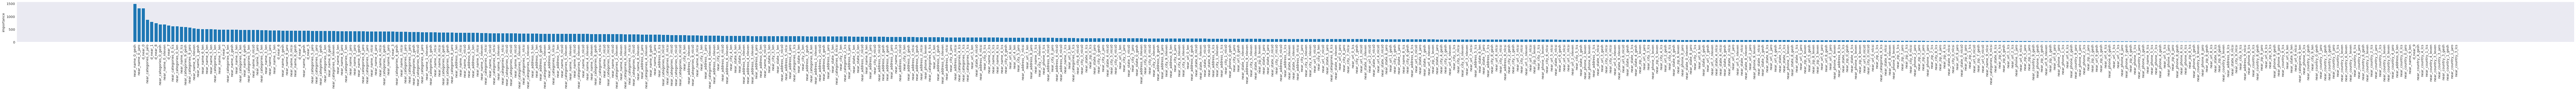

In [38]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importance(), 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

# Submit

In [1]:
ssub = pd.read_csv("../input/foursquare-location-matching/sample_submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()

# Further ideas

- fill the gaps in address/city/state/zip/country data with geofabric and osmconvert
- normalize unicode strings: https://www.kaggle.com/competitions/foursquare-location-matching/discussion/320938
- how to handle missing data https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python
- does sorting of categories make sense?
- mean/median/std encode features

In [83]:
ad = pd.read_csv('allCountries.txt', on_bad_lines='skip', sep='\t', names=['id', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature class', 'feature code', 'country code', 'cc2', 'admin1 code', 'admin2 code', 'admin3 code', 'admin4 code', 'population', 'elevation', 'dem', 'timezone', 'date'])
ad.drop(['asciiname', 'alternatenames', 'cc2', 'admin1 code', 'admin2 code', 'admin3 code', 'admin4 code', 'elevation', 'timezone', 'date', 'population', 'dem'], axis=1, inplace=True)
ad.head()

,id,name,latitude,longitude,feature class,feature code,country code
0,2986043,Pic de Font Blanca,42.64991,1.53335,T,PK,AD
1,2994701,Roc Mélé,42.58765,1.74028,T,MT,AD
2,3007683,Pic des Langounelles,42.61203,1.47364,T,PK,AD
3,3017832,Pic de les Abelletes,42.52535,1.73343,T,PK,AD
4,3017833,Estany de les Abelletes,42.52915,1.73362,H,LK,AD


A:
- ADM1
- ADM2
- ADM3
- ADM4
- ADM5
- ADMD
L
- AMUS
- CTRB
- DEVH
- LCTY
- PRK
- PRT
P
- PPL
- PPLA
- PPLA2	
- PPLA3		
- PPLA4		
- PPLA5
- PPLC
- PPLF
- PPLH
- PPLL
- PPLS
- PPLX
- STLMT
R
- any
S
- any



In [88]:
ad[(ad['feature class'] == 'A') & (ad['feature code'] == 'ZN')]

,id,name,latitude,longitude,feature class,feature code,country code
9326,11524242,Jebel Ali Free Zone,24.98595,55.05039,A,ZN,AE
93728,7302769,Tella e myhejanit,42.45183,20.11960,A,ZN,AL
681756,6695079,NATO,50.87650,4.42213,A,ZN,BE
682381,7648909,Brussel X-Luchthaven Remailing,50.90184,4.49169,A,ZN,BE
875603,10177607,Recife Metropolitan Area,-23.98333,-47.05000,A,ZN,BR
875651,10228320,Greater Rio de Janeiro,-22.90280,-43.20780,A,ZN,BR
1238970,6955983,Southwestern Ontario,42.18783,-82.87262,A,ZN,CA
2441569,7874632,Barrio Santa Isabel,4.60152,-74.10280,A,ZN,CO
2444999,8337214,Vereda Las Palmas,6.14324,-75.53980,A,ZN,CO
2945547,8692966,General Authority for Economic Zone North West...,29.65718,32.36052,A,ZN,EG
